In [ ]:
import pandas as pd
import nibabel as nib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
import sys
sys.path.append('..')
import sfp
import pyPyrTools as ppt
import math
from scipy import stats
from scipy import optimize as opt
import torch
import glob
import os
import warnings
import itertools

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
sns.set_style('whitegrid')
df_path = "/home/billbrod/Data/spatial_frequency_preferences/derivatives/first_level_analysis/stim_class/posterior/sub-wlsubj045/ses-02/sub-wlsubj045_ses-02_task-sfp_v1_e1-12_summary.csv"

# Model motivation

To explain the motivation behind this model, let's step through some reasoning.

In [ ]:
# Load in data

#df_path = "/scratch/wfb229/spatial_frequency_preferences/derivatives/first_level_analysis/stim_class/posterior/sub-wlsubj045/ses-02/sub-wlsubj045_ses-02_task-sfp_v1_e1-12_summary.csv"
df_path = "/home/billbrod/Data/spatial_frequency_preferences/derivatives/first_level_analysis/stim_class/posterior/sub-wlsubj045/ses-02/sub-wlsubj045_ses-02_task-sfp_v1_e1-12_summary.csv"
#df = pd.read_csv(df_path)

In [ ]:
# This is necessary for now, so we normalize values across voxels, but eventually we'll take care of this during the first level analysis
gb = df.groupby(['varea', 'voxel'])
df = df.set_index(['varea', 'voxel'])
df['amplitude_estimate_norm'] = gb.amplitude_estimate_median.apply(np.linalg.norm, 2)
df = df.reset_index()
df['amplitude_estimate_median_normed'] = df.amplitude_estimate_median / df.amplitude_estimate_norm

Let's look at some voxels that have good GLM $R^2$ values and pick one

In [ ]:
df[(df.varea==1)&(df.R2>55)].drop_duplicates('voxel').sort_values('R2', ascending=False).head(20)[['voxel', 'R2', 'varea', 'hemi', 'angle' ,'eccen', 'precision']]

In [ ]:
# Pick a V1 voxel with a good R2
voxel_df = df[(df.voxel.isin([264]))]#, 1421]))]
voxel_df.head()

In [ ]:
sns.set_context('notebook')
sns.set_style('white')

In [ ]:
pal = sns.palettes.color_palette('deep', 5)
pal = {'radial': pal[0], 'reverse spiral': pal[4], 'forward spiral': pal[2], 'angular': pal[3], 'mixtures': pal[1]}
hue_order = ['radial', 'reverse spiral', 'forward spiral', 'angular', 'mixtures']

Let's examine the response of this voxel as a function of spatial frequency. In the plot below, we plot the normed amplitude estimate as a function of the local spatial frequency. We see that the response looks roughly log-Normal, but there appears to be some difference between the different stimulus classes.

In [ ]:
g = sns.FacetGrid(voxel_df[~voxel_df.stimulus_superclass.isin(['mixtures'])], hue='stimulus_superclass',palette=pal, size=8, aspect=1.5, hue_order=hue_order)
g.map(plt.scatter, 'local_sf_magnitude', 'amplitude_estimate_median', linewidth=6)
g.map(plt.plot, 'local_sf_magnitude', 'amplitude_estimate_median', linewidth=6)
# g.ax.set_xscale('log', basex=2)
g.add_legend()
g.ax.tick_params(size=0)
g.ax.set_xlim((0, 6))
g.set_xlabels('Local spatial frequency (cpd)')
g.set_ylabels('Amplitude Estimate')

These classes differ in their local orientation, so we can look at a plot of the response as a function of the local spatial frequency with respect to x and y (size represents the response). This plot is difficult to parse, but the main point is that these different stimulus classes are not arbitrary and discrete: they lie on a continuum, related by the stimulus orientation, and so we can fit the response of the voxel as a 2d tuning curve.

In [ ]:
def scatter_sizes(x, y, s, plot_color=False, cmap=None, size_scale=1, **kwargs):
    if plot_color:
        kwargs.pop('color')
        if cmap is None:
            cmap = 'Blues'
        plt.scatter(x, y, s=s*80*size_scale, c=s, cmap=cmap, **kwargs)
    else:
        plt.scatter(x, y, s=s*80*size_scale, **kwargs)

with sns.axes_style('whitegrid'):
    voxel_df['normalized_resp'] = voxel_df['amplitude_estimate_median'].copy()
    voxel_df['normalized_resp'] = (voxel_df['normalized_resp'] - voxel_df['normalized_resp'].min()) / (voxel_df['normalized_resp'].max() - voxel_df['normalized_resp'].min())
    g=sns.FacetGrid(voxel_df, size=8, aspect=1, hue='stimulus_superclass', palette=pal, hue_order=hue_order)
    g.map(scatter_sizes, 'local_w_x', 'local_w_y', 'normalized_resp', plot_color=False, size_scale=2)
    g.add_legend()
    scatter_ax = plt.gca()
    scatter_ax.set_aspect('equal')
    g.ax.tick_params(size=0)

This is just that same data, but rotated and plotted on a semi-log plots.

In [ ]:
with sns.axes_style('whitegrid'), sns.plotting_context('notebook'):
    g=sns.FacetGrid(voxel_df, hue='stimulus_superclass', size=5, aspect=1, palette=pal, hue_order=hue_order)
    g.map(scatter_sizes, 'local_w_r', 'local_w_a', 'normalized_resp')
    g.add_legend()
    scatter_ax = plt.gca()
    scatter_ax.set_xscale('symlog', basex=2, linthreshx=2**(-4))
    scatter_ax.set_yscale('symlog', basey=2, linthreshy=2**(-4))

But then the question is: how does the tuning change with orientation? Two possibilities are:

1. The preferred frequency of the tuning curve / mode of the log-Gaussian distribution changes with orientation.
2. The amplitude of the tuning curve changes with orientation.

Then there's the question of how either the mode or the amplitude changes with orientation. Let's assume it changes smoothly and periodically, symmetrically about 180 degrees (because 2d orientation is runs from 0 to 180 degrees). We'll examine three possibilities in the plots below, from left to right:

1. all orientation are equally important (mode/amplitude does not depend on orientation; constant)
2. horizontal or vertical is preferred, but the other is anti-preferred (sinusoid with frequency $2\theta$)
3. the cardinals are preferred, the obliques are anti-preferred (sinusoid with frequency $4\theta$)

The following plots show these three possibilities, with the top showing a plot of orientation vs mode/response, while the bottom shows this on an x/y plot: the line represents either the mode or the level set of the max amplitude.

In [ ]:
with sns.plotting_context('paper'), sns.axes_style('white'):
    x = np.linspace(.1, 30, 100)
    y = sfp.tuning_curves.log_norm_pdf(x,1, 6, .45)
    plt.plot(x, y, 'k')

In [ ]:
with sns.plotting_context('paper'):
    fig = plt.figure(figsize=(12,6))
    theta = np.linspace(0, np.pi, 1000)
    for i, f, title in zip(range(3), [0, 2, 4], ['1. constant', '2. horizontal', '3. cardinals']):
        r = (np.cos(f*theta) + 3) / 4
        ax = plt.subplot(2,3,i+1)
        ax.plot(theta, r)
        ax.tick_params(size=0)
        sns.despine(ax=ax)
        ax.set_title(title)
        ax = plt.subplot(2,3,4+i, projection='polar')
        ax.plot(theta, r)

Okay so then how do we set up the function that we're going to fit? First, let's look at the 1d log-Normal distribution we used before. Normally, this distribution is parameterized by $\mu$ and $\sigma^2$. These are *not* the mean and variance, the way they are for the regular Normal distribution. We'll keep using $\sigma^2$ but we'll use the mode, $M$ instead of $\mu$: $M = \exp(\mu - \sigma^2) \Rightarrow \mu = \ln(M) + \sigma^2$.

Thus, when we're modeling the response, $R$ as a 1d log-Normal tuning curve with respect to the spatial frequency $\omega$, it's: $R=A * \exp(-\frac{(\ln(\omega)-\ln(M)-\sigma^2)^2}{2\sigma^2})$.

Now we're extending this to make it 2d, as a funtion of spatial frequency $\omega$ and orientation $\theta$. To allow for the amplitude varying with orientation, we expand upon $A$ and make it orientation-dependent: $A_0 + A_1\cos2\theta + A_2\cos4\theta$. To allow the mode to vary, we make similarly make $M$ orientation-dependent: $M_0 + M_1\cos2\theta + M_2\cos4\theta$.

Putting it altogether we get:

$(A_0 + A_1\cos2\theta + A_2\cos4\theta)\exp(-\frac{(\ln(\omega)-\ln(M_0 + M_1\cos2\theta + M_2\cos4\theta)-\sigma^2)^2}{2\sigma^2})$

which gives us 7 parameters to fit: $A_0, A_1, A_2, M_0, M_1, M_2, \sigma$

Let's look at some examples of this function, to get a sense of its expressive power.

In [ ]:
omega = np.logspace(-3, 3, 100, base=2)
theta = np.linspace(0, 2*np.pi, 100)

def log_norm_2d(omega, theta, A0=1, A1=0, A2=0, M0=1, M1=0, M2=0, sigma=1):
    omega = np.array(omega)
    theta = np.array(theta)
    amp = A0 + A1*np.cos(2*theta) + A2*np.cos(4*theta)
    mode = M0 + M1*np.cos(2*theta) + M2*np.cos(4*theta)
    #pdf = (1/(omega*sigma*np.sqrt(2*np.pi))) * np.exp(-(np.log(omega)-mu)**2/(2*sigma**2))
    #pdf /= pdf.max()
    pdf = sfp.tuning_curves.log_norm_pdf(omega, amp, mode, sigma)
    return pdf

omega, theta = np.meshgrid(omega, theta)

In [ ]:
fig, axes = plt.subplots(2, 3, subplot_kw={'projection': 'polar'}, figsize=(12, 6))

params = [{}, {'M0': .5}, {'A1': .5}, {'M1': .5}, {'A1': .5, 'M1': .5, 'M0': 1}, {'A1': .5, 'M1': .5, 'M0':2}]

with sns.plotting_context('notebook'):
    for i, ax in enumerate(axes.flatten()):
        R = log_norm_2d(omega, theta, **params[i])
        ax.pcolormesh(theta, omega, R)
        ax.set_xticks([])
        ax.set_rticks([])

This is on a voxel-by-voxel basis, but what about across the whole area? To extend it to all of V1, let's consider two frames of reference: fixed and relative.

In the fixed frame, all voxels have the same tuning. Orientation, $\theta_f$, above refers to Cartesian, world-relate orientation so that $\theta_f=0$ corresponds to "to the right". Spatial frequency, $\omega_f$, means the local spatial frequency in the image. This encodes our "constant" extreme possibility from earlier.

In the relative frame, voxel tuning depends on its location in the retinotopic map. We remap orientation and spatial frequency so that $\theta_r=0$ corresponds to "away from the fovea" and spatial frequency is scaled by eccentricity: $\omega_r=\omega_f(e+b)$, where $e$ is the eccentricity of the voxel's pRF and $b$ is some constant.

We then sum these two versions of the model so that we have a 15-parameter model (two versions of the 7 parameters above, plus $b$) that we fit simultaneously to all of V1.

# Torch

Model is:

$\exp{\frac{-(\log_2(\omega) + \log_2(ae+b))^2}{2 \sigma^2}}$

In [ ]:
a=1
b=0
model = sfp.model.LogGaussianDonut(1, 1, a, b)
model.eval()

When we build the model like this, we see it has a number of desirable features (note that for this version, there is no effect of orientation or retinal angle, so a single 1d tuning curve at each eccentricity completely characterizes the response of a voxel there). The following plots the responses on a log (left) and linear (right) x axis, for the perfectly scaling model at four different (log-spaced) eccentricities. We see that the tuning curve is log-normal, response peaks at 1, that the spatial frequency that drives the maximum response doubles as the eccentricity halves, and that the standard deviation is 1 octave (thus, the width of the tuning curve is constant in log space, but increases with the mode in linear space).

In [ ]:
x = np.logspace(-6, 5, 1000)
es = [.5, 1, 2, 4]
fig, axes = plt.subplots(1,2, sharey='all', figsize=(15,5))
for e in es:
    # with this parameterization, orientation and retinal angle don't matter, so we just make them 0s
    r = model.forward(x, np.zeros_like(x), e*np.ones_like(x), np.zeros_like(x)).detach().numpy()
    axes[0].semilogx(x, r, label='eccentricity %s'%e, basex=2)
    axes[1].plot(x, r, label='eccentricity %s'%e)
    plt.legend()
axes[0].set(xlim=(2**-6, 2**6), xlabel='spatial frequency (log scale)')
axes[1].set(xlim=(0, 10), xlabel='spatial frequency (linear scale)')

We can see what this looks like a little better by plotting the response as a heatmap, with eccentricity on the x-axis and period (the reciprocal of the spatial frequency) on the y-axis. (We plot against the period because then this will be linear, rather than hyperbolic.) The solid line here shows the (analytic) mode of the responses, while the dashed lines show one standard deviation above and below

In [ ]:
eccen = np.linspace(0.01, 12, 120)
period = np.linspace(.01, eccen.max()*a+b, 100)
resps = np.zeros((100, 120))
for i, e in enumerate(eccen):
    r = model.evaluate(1./period, np.zeros_like(period), e*np.ones_like(period), np.zeros_like(period)).detach()
    resps[:,i] = r

In [ ]:
ax = plt.imshow(resps, origin='lower', extent=(eccen.min(), eccen.max(), period.min(), period.max()), aspect='auto')
plt.ylabel('Period')
plt.xlabel('Eccentricity')
plt.plot(eccen,(a*eccen+b))
plt.plot(eccen,(a/2.*eccen+b), 'b--')
y = a*2*eccen+b
plt.plot(eccen[y<period.max()],y[y<period.max()], 'b--')
plt.colorbar()

Clean this up and explain it

In [ ]:
theta = np.linspace(0, np.pi, 100, endpoint=False)
model = LogGaussianDonut(1, 1, 0, .5, 0, .25, .5, 'relative')
plt.plot(theta, model.preferred_period(theta, 1, [0, np.pi/4, np.pi/2]).detach().numpy().T)
plt.plot(theta, model.max_amplitude(theta, [0, np.pi/4, np.pi/2]).detach().numpy().T, '--')
#model.preferred_period(theta, [1,2], 0)

In [ ]:
theta = np.linspace(0, np.pi, 100, endpoint=False)
model = LogGaussianDonut(1, 1, 0, .5, 0, 0, 1, 'relative')
plt.plot(theta, model.preferred_period(theta, [1,2, .5], 0).detach().numpy().T)
plt.plot(theta, model.max_amplitude(theta, 0).detach().numpy(),'k--')
#model.preferred_period(theta, [1,2], 0)

In [ ]:
x = np.logspace(-6, 5, 1000)
e = 1
fig, axes = plt.subplots(1,1, True,True, figsize=(10,5))
theta = [0, np.pi/4, np.pi/2, 3*np.pi/4]
for i, a in enumerate(theta):
    r = model.forward(x, a*np.ones_like(x), e*np.ones_like(x), np.zeros_like(x)).detach().numpy()
    axes.semilogx(x, r, basex=2, label='orientation %.03f' % a,)
plt.legend()
axes.set(xlim=(2**-6, 2**5))

In [ ]:
model = LogGaussianDonut(1, 1)

x = np.linspace(-5, 5, 1001)
eccens = [1,2,4]
angles = [0, np.pi]
fig, axes = plt.subplots(len(angles), len(eccens), True, True, figsize=(10,5))
for (a, e), ax in zip(itertools.product(angles, eccens), axes.flatten()):
    f = ax.imshow(model.create_image(e, a, (x.min(), x.max())).detach(), extent=(x.min(),x.max(), x.min(), x.max()), cmap='Reds')
    ax.set_title("eccen %s, angle %.03f" % (e, a))

In [ ]:
model = LogGaussianDonut(1, 1, mode_cardinals=.75,mode_obliques=.5)

x = np.linspace(-5, 5, 1001)
eccens = [1,2,4]
angles = [0, np.pi]
fig, axes = plt.subplots(len(angles), len(eccens), True, True, figsize=(10,5))
for (a, e), ax in zip(itertools.product(angles, eccens), axes.flatten()):
    f = ax.imshow(model.create_image(e, a, (x.min(), x.max())).detach(), extent=(x.min(),x.max(), x.min(), x.max()), cmap='Reds', origin='lower')
    ax.set_title("eccen %s, angle %.03f" % (e, a))

In [ ]:
x = np.logspace(-6, 5, 1000)
angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
e = 1
fig, axes = plt.subplots(1,1, True,True, figsize=(10,5))
for i, a in enumerate(angles):
    r = model.forward(x, a*np.ones_like(x), e*np.ones_like(x), np.zeros_like(x)).detach().numpy()
    axes.semilogx(x, r,'--', basex=2, label='orientation %.03f' % a,)
plt.legend()
axes.set(xlim=(2**-6, 2**5))

# Run some things 

In [ ]:
s = sfp.simulate_data.main(1, .5, .5, 0, .5, 1, 0, 'absolute', save_path='tmp.csv',)# noise_level=1, noise_source_path=df_path)
m,l,r = sfp.model.main('full_absolute', 'tmp.csv', stimulus_class=[0,1])

In [ ]:
sns.relplot('epoch_num', 'loss', 'data_subset', data=l, kind='line')

In [ ]:
x = np.linspace(0, np.pi, 100)
e = np.linspace(0, 12, 100)
a = m.preferred_period(0, e, 0).detach().numpy()
plt.plot(e, a)

# Analyzing outputs

In [ ]:
m, l, r = sfp.analyze_model.load_single_model('/home/billbrod/Data/spatial_frequency_preferences/derivatives/tuning_2d_simulated/sim-full/absolute/noise-stim_class_posterior_sub-wlsubj045_ses-02_task-sfp_v1_e1-12/sim-full_n5000_s1_e.75_i.25_l1_b10_r1e-2_g1_full')

With only measurement noise in the simulated data, we have the following performance, reaching a loss of about .075

In [ ]:
l.groupby('epoch_num').loss.mean()

In [7]:
models, loss_df, results_df = sfp.analyze_model.combine_models('/home/billbrod/Data/spatial_frequency_preferences/derivatives/tuning_2d_simulated/absolute/noise-stim_class_posterior_sub-wlsubj045_ses-02_task-sfp_v1_e1-12/*', True)

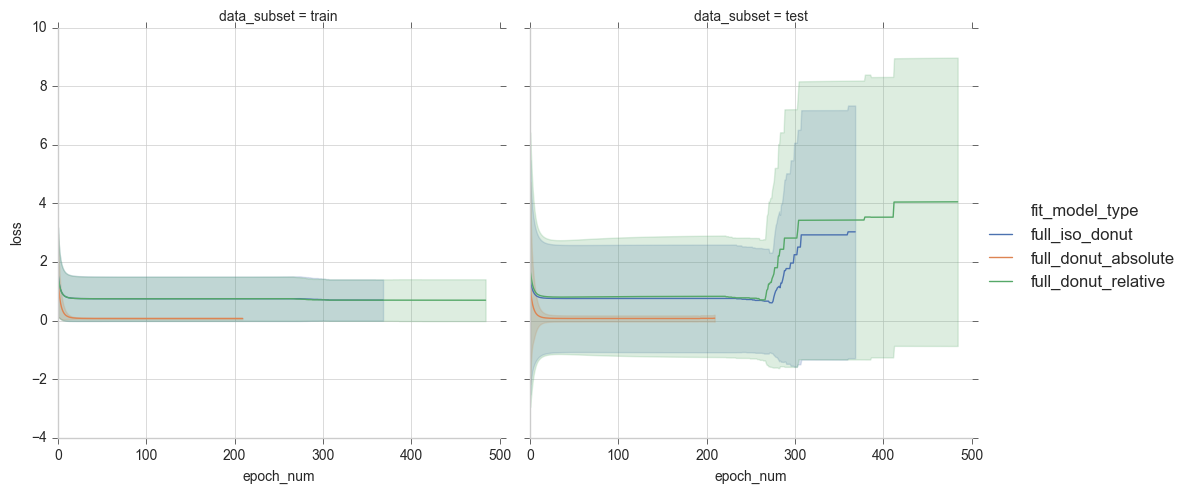

In [8]:
g = sns.relplot('epoch_num', 'loss', 'fit_model_type', data=loss_df, col='data_subset', kind='line', ci='sd', palette=sns.color_palette('deep', 3) )
                #facet_kws={'sharey':False, 'sharex': False})


In [12]:
grouped_loss = loss_df.groupby(['data_subset','fit_model_type', 'test_subset', 'epoch_num']).loss.mean().reset_index()
grouped_loss = grouped_loss.groupby(['data_subset', 'fit_model_type', 'test_subset']).last().reset_index()

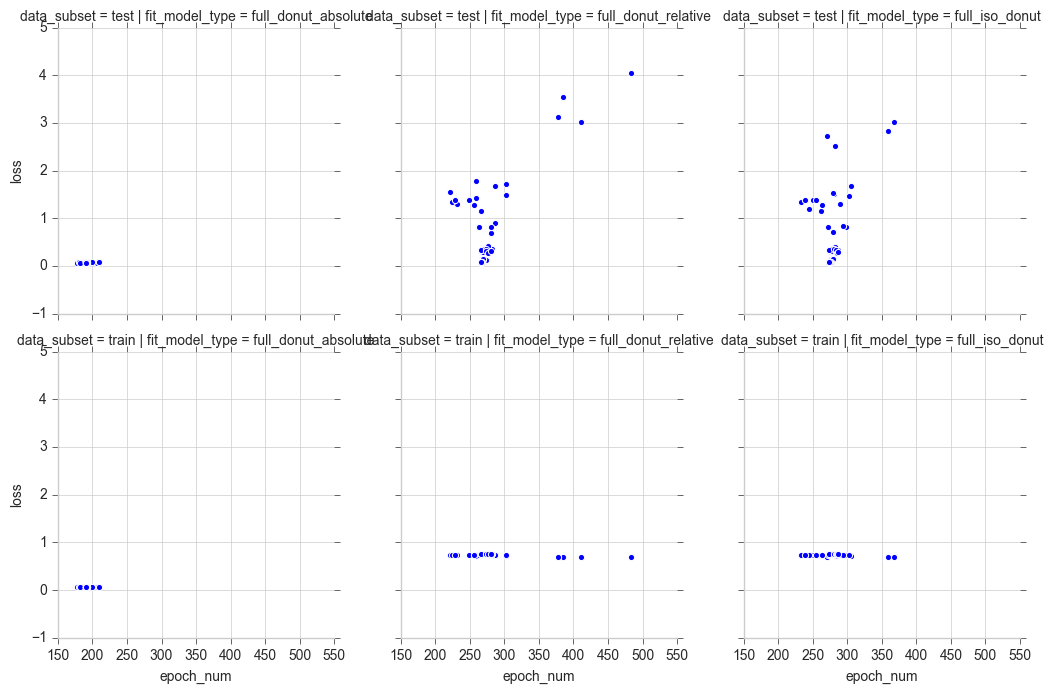

In [20]:
sns.relplot('epoch_num', 'loss', data=grouped_loss, col='fit_model_type', row='data_subset', height=3.5)

In [14]:
grouped_loss.groupby(['data_subset', 'fit_model_type']).loss.mean().reset_index().sort_values(['data_subset', 'loss'])

,data_subset,fit_model_type,loss
0,test,full_donut_absolute,0.071730
2,test,full_iso_donut,0.755897
1,test,full_donut_relative,0.831228
3,train,full_donut_absolute,0.071541
4,train,full_donut_relative,0.743617
5,train,full_iso_donut,0.744523


In [28]:
0.007203/(.071730/(5678/100))

5.623421162693433

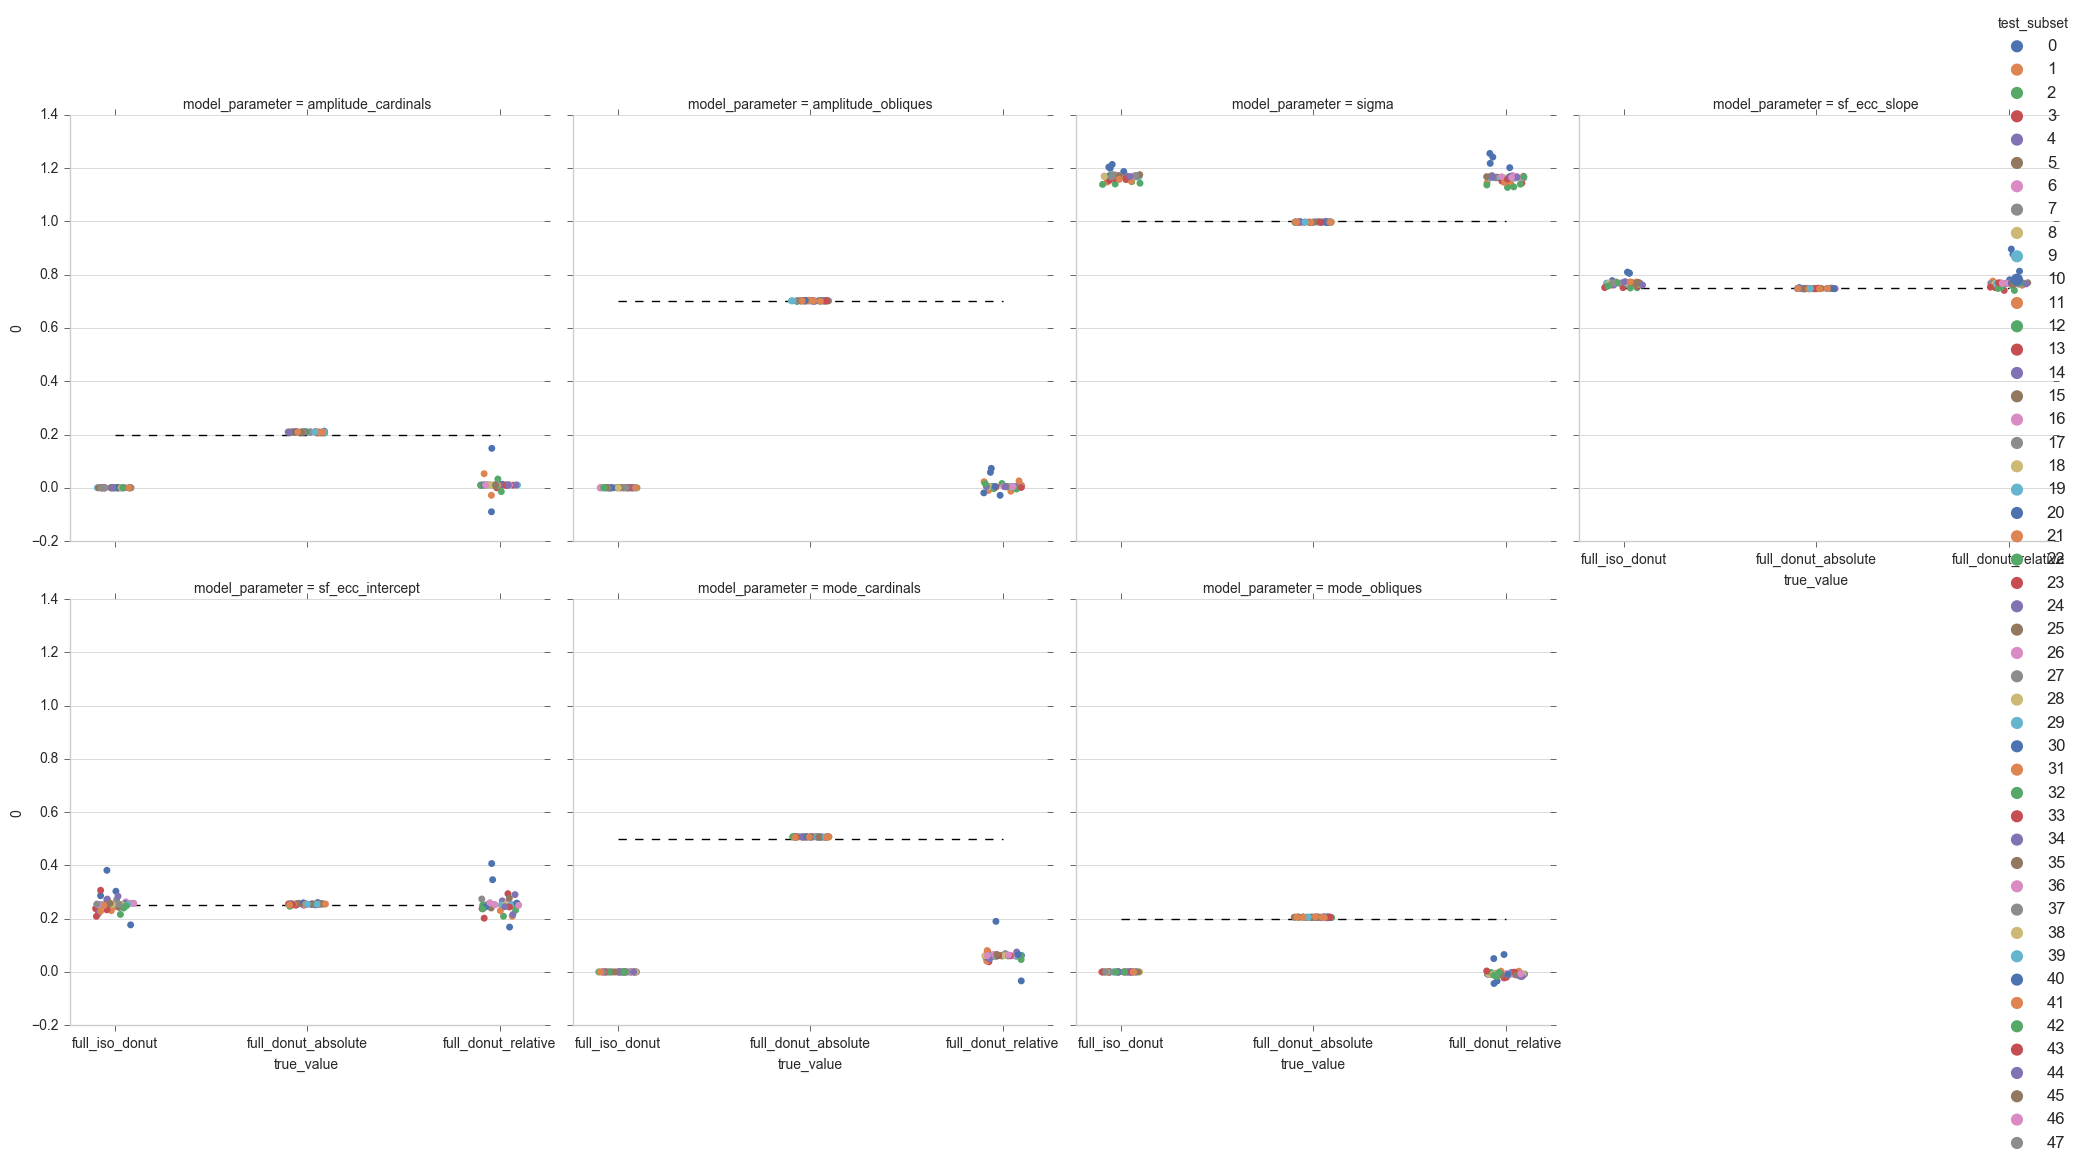

In [11]:
def custom_hline(y, xmin, xmax, **kwargs):
    data = kwargs.pop('data')
    kwargs.pop('color')
    if data[y].nunique() > 1:
        warnings.warn("No unique value, so can't plot!")
    else:
        plt.hlines(data[y].unique()[0], xmin, xmax, **kwargs)
    
g = sns.catplot('fit_model_type', 'fit_value', 'test_subset', data=models, col='model_parameter', 
                kind='strip', ci='sd', palette=sns.color_palette('deep', 48), col_wrap=4)
g.map_dataframe(custom_hline, 'true_value', 0, 2, linestyles='dashed')

In [10]:
eccen = np.linspace(.01, 10, 120)
plt.plot(eccen, m.preferred_period(0,eccen, 0).detach().numpy())

NameError: name 'm' is not defined

In [ ]:
m, l, f = sfp.analyze_model.load_single_model('/home/billbrod/Data/spatial_frequency_preferences/derivatives/tuning_2d_model/stim_class/posterior/sub-wlsubj045/ses-02/sub-wlsubj045_ses-02_task-sfp_v1_e1-12_summary_b10_r1e-2_full')
m

In [ ]:
a = m.sf_ecc_slope.detach().numpy()
b = m.sf_ecc_intercept.detach().numpy()
s = m.sigma.detach().numpy()
eccen = np.linspace(0.01, 10, 120)
period = np.linspace(.01, 2, 100)
resps = np.zeros((100, 120))
for i, e in enumerate(eccen):
    r = m.evaluate(1./period, np.zeros_like(period), e*np.ones_like(period), np.zeros_like(period)).detach()
    resps[:,i] = r

In [ ]:
ax = plt.imshow(resps, origin='lower', extent=(eccen.min(), eccen.max(), period.min(), period.max()), aspect='auto')
plt.ylabel('Period')
plt.xlabel('Eccentricity')
plt.plot(eccen,(a*eccen+b))
#plt.plot(eccen,(a/(1+s)*eccen+b), 'b--')
y = (1+s)*a*eccen+b
#plt.plot(eccen[y<period.max()],y[y<period.max()], 'b--')
plt.colorbar()
plt.savefig('new_results.pdf')

In [ ]:
g = sns.FacetGrid(results_df.drop_duplicates(['voxel', 'fit_model_type', 'batch_size']), col='fit_model_type',hue='batch_size', height=5)
g.map(sns.distplot, 'model_prediction_loss', kde=False, bins=np.linspace(0, results_df.model_prediction_loss.max(), 20))
g.add_legend()

In [ ]:
g = sns.FacetGrid(results_df.drop_duplicates(['voxel', 'fit_model_type', 'batch_size']), col='fit_model_type', hue='batch_size', height=5)
g.map(sns.distplot, 'model_prediction_correlation', kde=False, bins=np.linspace(-1, 1, 20))
g.add_legend()

In [ ]:
voxel_df = results_df[results_df.voxel == results_df.voxel.unique()[0]]

In [ ]:
g = sns.FacetGrid(voxel_df, col='fit_model_type', hue='rounded_freq_space_distance',palette=sns.color_palette('Blues', 11), size=5)
g.map(plt.scatter, 'amplitude_estimate_median', 'model_predictions')
g.add_legend()

In [ ]:
best_voxels = results_df[(results_df.batch_size==10)&(results_df.fit_model_type=='full_donut')&(results_df.model_prediction_loss<.001)]
print(best_voxels.voxel.nunique())

In [ ]:
g = sns.FacetGrid(best_voxels, hue='rounded_freq_space_distance', col='stimulus_superclass', palette=sns.color_palette('Blues',11), size=5)
g.map(plt.scatter, 'amplitude_estimate_median', 'model_predictions')
xlim = g.axes.flatten()[0].get_xlim()
ylim = g.axes.flatten()[0].get_ylim()
for ax in g.axes.flatten():
    ax.plot(xlim, xlim, 'k--')
g.set(xlim=xlim, ylim=ylim)
g.add_legend()

Batch size is a hyper parameter to play around with, not a good rule of thumb for how to pick, except that it should be vary inversely with learning rate (less important with Adam, since it dynamically updates it, but still). Batch shouldn't just be as large as possible, computationally, because there are some results showing it acts as a regularizer (computing the gradient with the full dataset is hard).

Should calculate loss over whole epoch and keep going until loss changes by less than some threshold for 3 or 4 epochs in a row. Every so many epochs, spit out results to keep track of progress.

https://pytorch.org/docs/0.4.0/nn.html#dataparallel-layers-multi-gpu-distributed

https://pytorch.org/tutorials/beginner/blitz/data_parallel_tutorial.html

Use DataParallel to split across multiple GPUs and speed up a given batch (so batch needs to be large enough for this to work)

In [ ]:
print(list(constant_donut.named_parameters()))
print(list(scaling_donut.named_parameters()))
dataset = sfp.model.FirstLevelDataset("tmp.csv", device)

In [ ]:
constant_donut, constant_loss = sfp.model.train_model(constant_donut, dataset, 1)

In [ ]:
scaling_donut, scaling_loss = sfp.model.train_model(scaling_donut, dataset, device, 20)

In [ ]:
constant_donut.eval()
print(list(constant_donut.named_parameters()))

scaling_donut.eval()
print(list(scaling_donut.named_parameters()))

In [ ]:
sns.pointplot('eccen', 'amplitude_estimate_median_normed', data=df, join=False)

In [ ]:
sns.distplot(df.groupby('voxel').amplitude_estimate_median_normed.mean())

In [ ]:
sns.distplot(df.amplitude_estimate_median_normed.values)

In [ ]:
sns.pointplot('eccen', 'amplitude_estimate_median', data=df, join=False)

In [ ]:
def construct_loss_df(loss_history):
    loss_history = np.array(loss_history)
    loss_df = pd.DataFrame(loss_history)
    loss_df = pd.melt(loss_df.reset_index(), id_vars='index',var_name='batch_num', value_name='loss', ).rename(columns={'index': 'epoch_num'})
    return loss_df

In [ ]:
constant_loss_df = construct_loss_df(constant_loss)
scaling_loss_df = construct_loss_df(scaling_loss)

In [ ]:
constant_loss_df['model'] = 'constant'
scaling_loss_df['model'] = 'scaling'

In [ ]:
loss_df = pd.concat([constant_loss_df, scaling_loss_df]).reset_index()

In [ ]:
sns.pointplot('epoch_num', 'loss', 'model', data=loss_df, )

In [ ]:
list(donut.named_parameters())

In [ ]:
df = pd.read_csv('tmp.csv')

In [ ]:
ds = sfp.model.FirstLevelDataset('tmp.csv', torch.device('cuda:0'), df_filter=sfp.model.drop_negative_amplitudes)

In [ ]:
corrs = []
for i in df.voxel.unique():
    actuals = ds.get_voxel(i)[1]
    preds = donut(*ds.get_voxel(i)[0].transpose(0, 1))
    corr = np.corrcoef(actuals.cpu().detach().numpy(), preds.cpu().detach().numpy())
    corrs.append([i, corr[0,1], loss_fn(preds, actuals.to(device)).item()])

corrs = pd.DataFrame(corrs, columns=['voxel', 'correlation', 'loss'])
df = df.set_index('voxel')
corrs = corrs.set_index('voxel')
corrs = corrs.join(df[['eccen']], 'voxel',).drop_duplicates().reset_index()
df = df.reset_index()

In [ ]:
sns.distplot(corrs['correlation'])

In [ ]:
sns.distplot(corrs['loss'])

In [ ]:
sns.scatterplot('eccen', 'correlation', data=corrs)

In [ ]:
x = np.linspace(-5, 5, 1001)
xgrid, ygrid = np.meshgrid(x, x)
# detach() is required to separate it from the graph implied by setting `requires_grad=True` above
plt.imshow(donut.create_image(10, np.pi, (x.min(), x.max())).detach(), extent=(x.min(),x.max(), x.min(), x.max()), cmap='Reds')
plt.colorbar()

In [ ]:
x = np.linspace(-5, 5, 1001)
xgrid, ygrid = np.meshgrid(x, x)
# detach() is required to separate it from the graph implied by setting `requires_grad=True` above
plt.imshow(donut.create_image(.01, np.pi, (x.min(), x.max())).detach(), extent=(x.min(),x.max(), x.min(), x.max()), cmap='Reds')
plt.colorbar()

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20,5))
vals = [y.cpu().detach().numpy(), y_pred.cpu().detach().numpy(), y.cpu().detach().numpy() - y_pred.cpu().detach().numpy()]
titles = ['ground truth', 'predicted', 'ground truth - predicted']
for ax, v, t in zip(axes.flatten(), vals, titles):
    scaled_v = (v - abs(v).min()) / (abs(v).max() - abs(v).min())
    pts=ax.scatter(voxel_df['local_w_x'], voxel_df['local_w_y'], s=abs(scaled_v)*50, c=v, cmap='RdBu_r', norm=sfp.plotting.MidpointNormalize(midpoint=0))
    ax.set_aspect('equal')
    plt.colorbar(pts, ax=ax, shrink=.6)
    ax.set(xlim=(-4.5, 4.5), ylim=(-.5, 5))
    ax.set_title(t)

In [ ]:
x = np.linspace(-8, 8, 1001)
# detach() is required to separate it from the graph implied by setting `requires_grad=True` above
plt.imshow(donut.create_image((x.min(), x.max())).cpu().detach(), extent=(x.min(),x.max(), x.min(), x.max()),cmap='RdBu_r', norm=sfp.plotting.MidpointNormalize(midpoint=0))
ax = plt.gca()
ax.set(xlim=(-4.5, 4.5), ylim=(-.5, 5))
plt.colorbar(shrink=.7)